Set colab to access the images in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

Import the required libraries

In [ ]:
import os   # To navigate into the drive folders and access the images
import matplotlib.pyplot as plt   # To make plots
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator  # To process images in batches and apply transformations
from keras.applications import Xception  # Import the VGG19 model
from keras.models import Sequential    # Allow us to add another layer to the pretrained model that makes the classification
from keras.layers import Flatten, Dense, Dropout   # Flatten the output layer to make it able for input in the Dense layer
from keras.optimizers import Adam    # Import the Adam optimizer


Defining paths to our images

In [ ]:
# Define the base directory where your 'sample' folder is located
base_dir = '/content/drive/My Drive/Sample'

# Define the paths to the training, validation, and testing directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Base model

Data normalization and ImageDataGenerator instances to access the images.

In [ ]:
# Rescale the pixel values from [0, 255] to [0, 1] for normalization

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=32,  # It will be iterating from batches of 20 images
    class_mode= 'binary'  # Label the images in a binary way (Fake or Real)
)

Validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=32,  # It will be iterating from batches of 20 images
    class_mode= 'binary'  # Label the images in a binary way (Fake or Real)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=20,  # It will be iterating from batches of 20 images
    class_mode= 'binary',  # Label the images in a binary way (Fake or Real)
    shuffle=False)  # No need to shuffle the test data

Found 3399 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Xception model, good training, bad testing AND Test loss: 0.8759, Test accuracy: 0.8167

In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.applications import Xception


# Load the Xception model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu'),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid')  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/4/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)


history = model.fit(
    train_generator,
    steps_per_epoch= 88,
    epochs=num_epochs,
    validation_data=Validation_generator,
    validation_steps = 26,
    callbacks=[model_checkpoint]
)

Epoch 1/20
88/88 [==============================] - ETA: 0s - loss: 1.3869 - accuracy: 0.7678 
Epoch 1: saving model to /content/drive/My Drive/checkpoints/Xception2/4/model_epoch_01_val_accuracy_0.8653.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 1774s 20s/step - loss: 1.3869 - accuracy: 0.7678 - val_loss: 0.3541 - val_accuracy: 0.8653
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.8596
Epoch 2: saving model to /content/drive/My Drive/checkpoints/Xception2/4/model_epoch_02_val_accuracy_0.9052.h5
88/88 [==============================] - 46s 522ms/step - loss: 0.3445 - accuracy: 0.8596 - val_loss: 0.2585 - val_accuracy: 0.9052
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.8710
Epoch 3: saving model to /content/drive/My Drive/checkpoints/Xception2/4/model_epoch_03_val_accuracy_0.9102.h5
88/88 [==============================] - 47s 530ms/step - loss: 0.3166 - accuracy: 0.8710 - val_loss: 0.2341 - val_accuracy: 0.9102
Epoch 4/20
88/88 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.8807
Epoch 4: saving model to /content/drive/My Drive/checkpoints/Xception2/4/model_epoch_04_val_accuracy

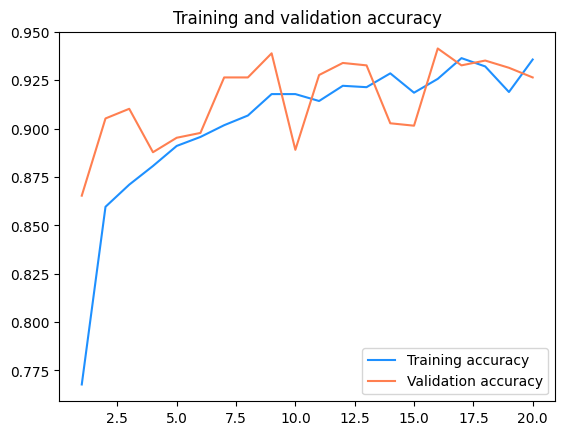

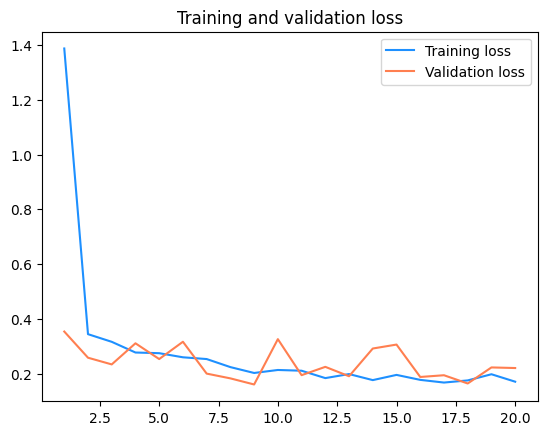

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/4/model_epoch_18_val_accuracy_0.9352.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 3s 132ms/step - loss: 0.8759 - accuracy: 0.8167
Test loss: 0.8759, Test accuracy: 0.8167


19/19 [==============================] - 3s 133ms/step


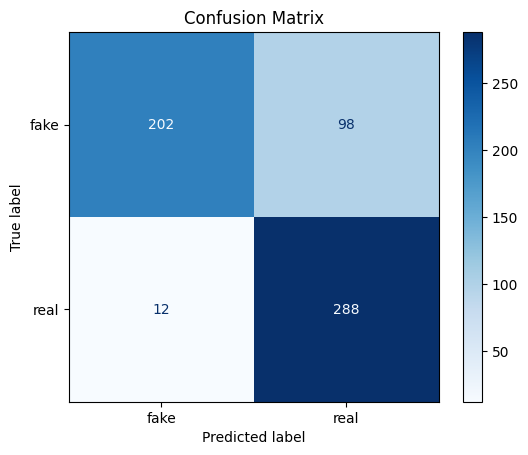

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Xception Model with regularization, Test loss: 0.8260, Test accuracy: 0.7683


In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.applications import Xception


# Load the Xception model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/5/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)


history = model.fit(
    train_generator,
    steps_per_epoch= 88,
    epochs=num_epochs,
    validation_data=Validation_generator,
    validation_steps = 26,
    callbacks=[model_checkpoint]
)

Epoch 1/20
88/88 [==============================] - ETA: 0s - loss: 4.2455 - accuracy: 0.6927
Epoch 1: saving model to /content/drive/My Drive/checkpoints/Xception2/5/model_epoch_01_val_accuracy_0.8678.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 47s 504ms/step - loss: 4.2455 - accuracy: 0.6927 - val_loss: 1.2047 - val_accuracy: 0.8678
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 0.8975 - accuracy: 0.8185
Epoch 2: saving model to /content/drive/My Drive/checkpoints/Xception2/5/model_epoch_02_val_accuracy_0.8928.h5
88/88 [==============================] - 45s 509ms/step - loss: 0.8975 - accuracy: 0.8185 - val_loss: 0.5920 - val_accuracy: 0.8928
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.8149
Epoch 3: saving model to /content/drive/My Drive/checkpoints/Xception2/5/model_epoch_03_val_accuracy_0.8990.h5
88/88 [==============================] - 45s 506ms/step - loss: 0.6617 - accuracy: 0.8149 - val_loss: 0.4650 - val_accuracy: 0.8990
Epoch 4/20
88/88 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.8289
Epoch 4: saving model to /content/drive/My Drive/checkpoints/Xception2/5/model_epoch_04_val_accuracy

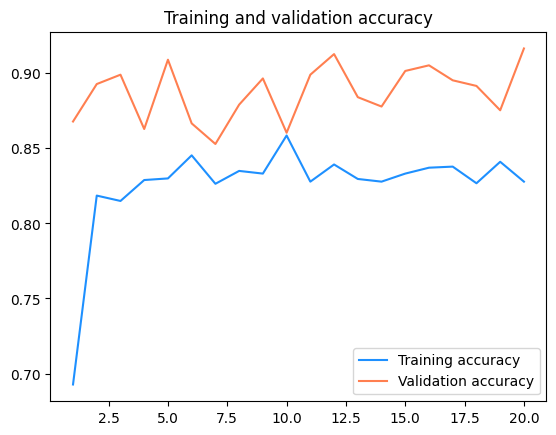

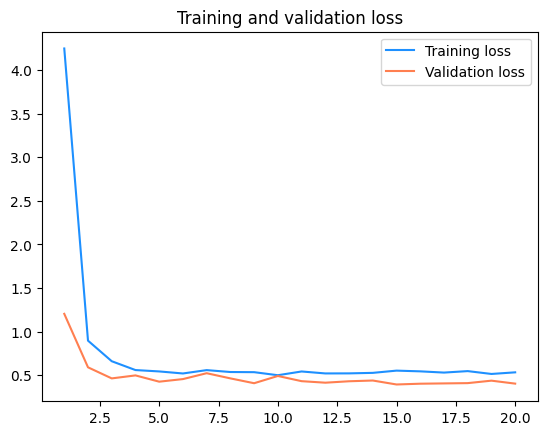

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/5/model_epoch_10_val_accuracy_0.8603.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 4s 167ms/step - loss: 0.8260 - accuracy: 0.7683
Test loss: 0.8260, Test accuracy: 0.7683


## Xception with more training data, Test loss: 0.3780, Test accuracy: 0.8450

---



In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.applications import Xception


# Load the Xception model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu'),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid')  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)


history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=Validation_generator,
    callbacks=[model_checkpoint]
)

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 1.4995 - accuracy: 0.7296
Epoch 1: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_01_val_accuracy_0.8716.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 1216s 11s/step - loss: 1.4995 - accuracy: 0.7296 - val_loss: 0.3138 - val_accuracy: 0.8716
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.8191
Epoch 2: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_02_val_accuracy_0.8853.h5
107/107 [==============================] - 73s 678ms/step - loss: 0.4202 - accuracy: 0.8191 - val_loss: 0.3114 - val_accuracy: 0.8853
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8267
Epoch 3: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_03_val_accuracy_0.9015.h5
107/107 [==============================] - 73s 679ms/step - loss: 0.4050 - accuracy: 0.8267 - val_loss: 0.2703 - val_accuracy: 0.9015
Epoch 4/20
107/107 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8355
Epoch 4: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_04_

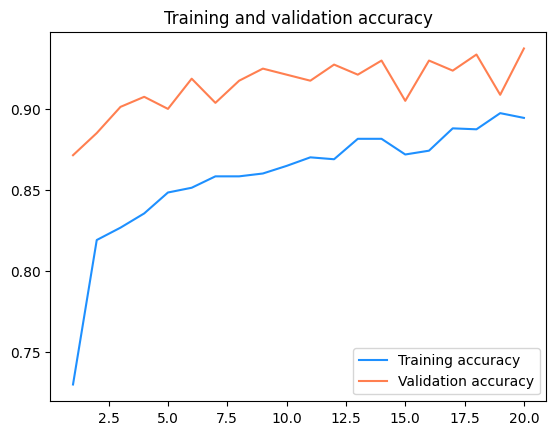

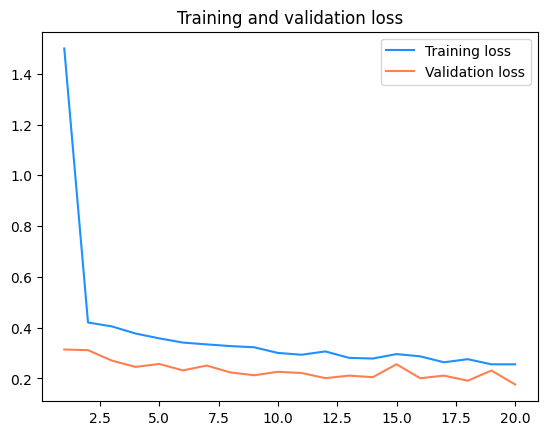

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_16_val_accuracy_0.9302.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 2s 77ms/step - loss: 0.3780 - accuracy: 0.8450
Test loss: 0.3780, Test accuracy: 0.8450


19/19 [==============================] - 2s 74ms/step


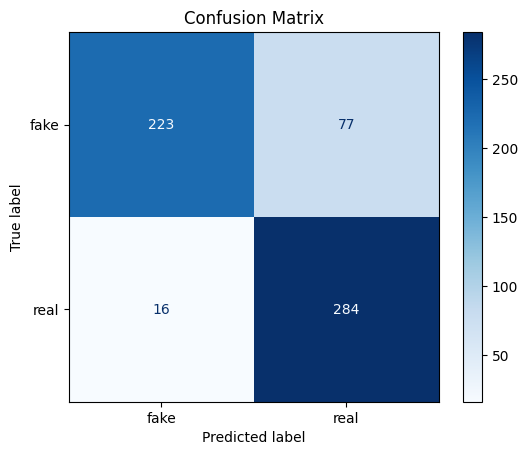

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Xception with more data, no dropout, Test loss: 0.3417, Test accuracy: 0.8467

> Add blockquote



Model is underftting a bit so we will remove dropout

In [ ]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.applications import Xception


# Load the Xception model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu'),  # Add a fully connected layer with 256 units and ReLU activation
    # Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid')  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)


history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=Validation_generator,
    callbacks=[model_checkpoint]
)

Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.7549
Epoch 1: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_01_val_accuracy_0.8915.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 76s 685ms/step - loss: 0.9787 - accuracy: 0.7549 - val_loss: 0.3394 - val_accuracy: 0.8915
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8258
Epoch 2: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_02_val_accuracy_0.8953.h5
107/107 [==============================] - 73s 681ms/step - loss: 0.4044 - accuracy: 0.8258 - val_loss: 0.2496 - val_accuracy: 0.8953
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8514
Epoch 3: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_03_val_accuracy_0.8865.h5
107/107 [==============================] - 73s 680ms/step - loss: 0.3566 - accuracy: 0.8514 - val_loss: 0.2968 - val_accuracy: 0.8865
Epoch 4/20
107/107 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8482
Epoch 4: saving model to /content/drive/My Drive/checkpoints/Xception2/7/model_epoch_04_

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_14_val_accuracy_0.9115.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 78s 3s/step - loss: 0.3419 - accuracy: 0.8467
Test loss: 0.3419, Test accuracy: 0.8467


19/19 [==============================] - 3s 118ms/step


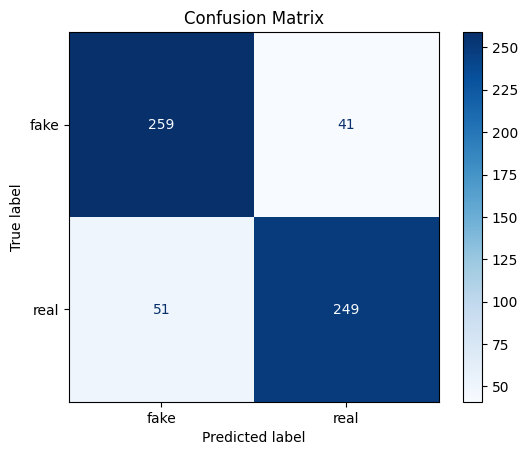

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()